In [18]:
# # Install necessary packages
# !pip install xgboost
# !pip install optuna

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

import shap
import optuna

# Global Configuration
base_dir = Path().resolve().parent

TUNE_MODE = True # Enable Optuna tuning
N_TRIALS = 20 # Number of trial for Optuna
SEED = 42

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

TUNE_MODE: ON | Optuna Trials: 20


In [3]:
# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_gene = pd.read_csv("/content/drive/MyDrive/Data/dataset/csv/transcriptomic_hvg.csv", index_col=0)
meta_data = pd.read_csv("/content/drive/MyDrive/Data/dataset/csv/metadata.csv", index_col=0)

In [5]:
#  Step 2: Prepare data for ML models

#  2.1 Select the top features

# Number of top features (genes) to retain
tr_n = 250

# Load list of Highly Variable Genes (HVGs) from a precomputed CSV
# Each gene name is expected to be in a single column, no header
# hvg_genes = pd.read_csv(base_dir / "dataset/csv/hvg_genes.csv",header=None).squeeze().tolist()

hvg_genes = pd.read_csv(
    "/content/drive/MyDrive/Data/dataset/csv/hvg_genes.csv",
    header=None
).squeeze().tolist()

# Keep only HVGs that exist in df_gene columns, preserving order
# Then select the top N genes (tr_n)
tr_top = [g for g in hvg_genes if g in df_gene.columns][:tr_n]

# Build the feature matrix (X) using the selected top genes
X= df_gene[tr_top]

# Align metadata with df_gene index and extract target column
y = meta_data.loc[df_gene.index,:]['response']


#  2.2 Encode target variable
# Convert categorical response labels to numeric (binary classification)
# 'Responder' -> 1, 'Non-responder' -> 0
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)

print(X.shape)

(52831, 250)


In [6]:
# 2.3 Split the data into training and test sets
# Split dataset into training and test sets (80% train, 20% test)
# Stratified split ensures class balance is preserved in both subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)


# 2.4 Standardize the features
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [7]:
# Step 3: Optuna for Hyper-parameter tunning

# 3.1 Optuna Objective Functions with class balance

# Compute class balance ratio
def class_balance(y):
    """
    Compute class imbalance ratio for weighting.
    Returns ratio (negative_count / positive_count).
    Used to compensate for imbalance in binary classification.
    """
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression Objective Function
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Logistic Regression using Optuna.
    Hyperparameter: Regularization strength (C).
    """
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest Objective Function
def tune_rf(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Random Forest using Optuna.
    Tuned hyperparameters include depth, splits, and max features.
    """
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost Objective Function
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning XGBoost using Optuna.
    Includes learning rate, depth, and subsampling parameters.
    """
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Artificial Neural Network (ANN) Objective Function
def tune_ann(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning a simple feed-forward ANN using Optuna.
    The model adapts to class imbalance via sample weighting.
    """
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)

[I 2025-10-19 08:41:31,347] A new study created in memory with name: no-name-9291513c-21e5-4e2c-9ca6-f73c70f5a537


Class balance ratio: neg/pos = 2.06


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 08:41:33,346] Trial 0 finished with value: 0.870535504193611 and parameters: {'C': 0.3181353148175679}. Best is trial 0 with value: 0.870535504193611.
[I 2025-10-19 08:41:34,888] Trial 1 finished with value: 0.8704500319121957 and parameters: {'C': 0.009386228861979854}. Best is trial 0 with value: 0.870535504193611.
[I 2025-10-19 08:41:36,408] Trial 2 finished with value: 0.8706049504222612 and parameters: {'C': 0.02801394183548746}. Best is trial 2 with value: 0.8706049504222612.
[I 2025-10-19 08:41:39,230] Trial 3 finished with value: 0.87040901284857 and parameters: {'C': 0.49049076012441695}. Best is trial 2 with value: 0.8706049504222612.
[I 2025-10-19 08:41:40,740] Trial 4 finished with value: 0.8689260942041905 and parameters: {'C': 0.00215729582254643}. Best is trial 2 with value: 0.8706049504222612.
[I 2025-10-19 08:41:42,676] Trial 5 finished with value: 0.869306331384684 and parameters: {'C': 0.002616981820276759}. Best is trial 2 with value: 0.870604950422261

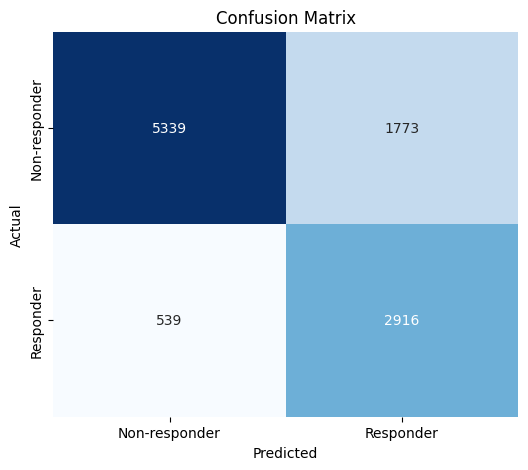

In [8]:
#  3.2 Run hyperparameter tuning and evaluation for Logistic Regression (LR)

# Step 1: Compute class balance
w = class_balance(y_train)
print(f"Class balance ratio: neg/pos = {w:.2f}")

# Step 2: Define and run Optuna study
name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study.best_value:.3f} | params={study.best_params}")


# Step 3: Refit model on the full training set by best parameters which obtains by Optuna
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )
model_lr.fit(X_train, y_train)

# Step 4: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_lr = model_lr.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_lr)
roc = roc_auc_score(y_test, y_prob_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["Non-responder", "Responder"]))

#  Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-19 08:42:10,705] A new study created in memory with name: no-name-6e1352f6-8c16-4a7c-9bfa-e7eaf7e11083


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 08:42:38,611] Trial 0 finished with value: 0.8579423336832779 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8579423336832779.
[I 2025-10-19 08:43:03,926] Trial 1 finished with value: 0.8607601843657461 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.8607601843657461.
[I 2025-10-19 08:43:44,007] Trial 2 finished with value: 0.8636830947274542 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8636830947274542.
[I 2025-10-19 08:45:35,756] Trial 3 finished with value: 0.8842913902702526 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.88429139027025

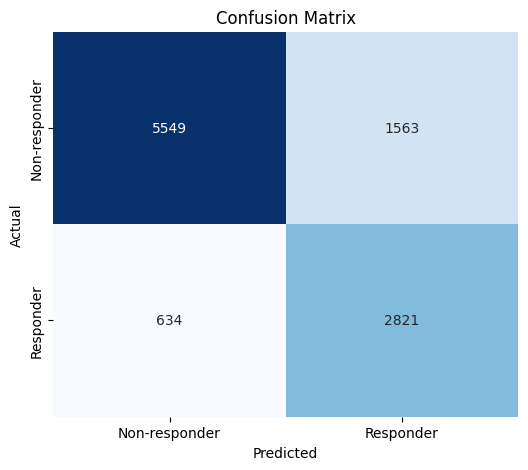

In [9]:
#  3.3 Run hyperparameter tuning and evaluation for Random Forest (RF)

# Step 1: Define and run Optuna study
name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})
model_rf.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_rf = model_rf.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-19 09:02:01,916] A new study created in memory with name: no-name-f8fb50b8-b680-4882-8925-a0f80af865a0


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-19 09:03:04,719] Trial 0 finished with value: 0.9162082918797008 and parameters: {'learning_rate': 0.09215640720763464, 'max_depth': 12, 'subsample': 0.6489258554072322, 'colsample_bytree': 0.9669696326620831, 'n_estimators': 200}. Best is trial 0 with value: 0.9162082918797008.
[I 2025-10-19 09:04:23,969] Trial 1 finished with value: 0.9108271630910338 and parameters: {'learning_rate': 0.014080443149778422, 'max_depth': 9, 'subsample': 0.8877457334028556, 'colsample_bytree': 0.6661486955133973, 'n_estimators': 400}. Best is trial 0 with value: 0.9162082918797008.
[I 2025-10-19 09:06:07,304] Trial 2 finished with value: 0.918723301041261 and parameters: {'learning_rate': 0.18557671645428192, 'max_depth': 9, 'subsample': 0.9871191743538452, 'colsample_bytree': 0.826474707535416, 'n_estimators': 1000}. Best is trial 2 with value: 0.918723301041261.
[I 2025-10-19 09:06:40,637] Trial 3 finished with value: 0.9072391079441143 and parameters: {'learning_rate': 0.016303476070456603

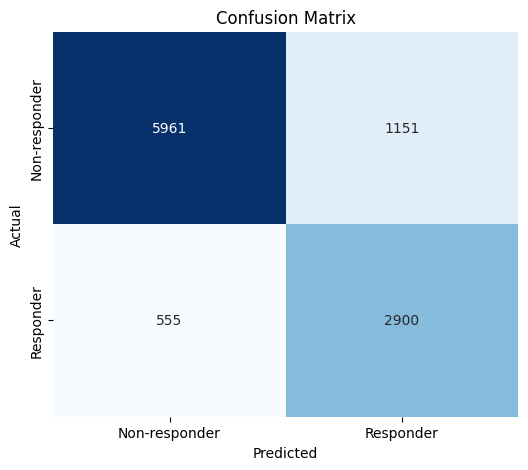

In [10]:
#  3.4 Run hyperparameter tuning and evaluation for XGBoost (XGB)

# Step 1: Define and run Optuna study
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)
model_gb.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_gb = model_gb.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-19 09:33:56,704] A new study created in memory with name: no-name-2d0c8cf9-2166-4902-8f35-78238bdc0595


  0%|          | 0/20 [00:00<?, ?it/s]

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[I 2025-10-19 09:35:14,006] Trial 0 finished with value: 0.9018223975025813 and parameters: {'lr': 0.0016958980501409215, 'dropout': 0.5685138376637036, 'n1': 64, 'n2': 48}. Best is trial 0 with value: 0.9018223975025813.
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-19 09:36:29,948] Trial 1 finished with value: 0.89575144889508 and parameters: {'lr': 0.008971414867200779, 'dropout': 0.3557008755472005, 'n1': 96, 'n2': 64}. Best is trial 0 with value: 0.9018223975025813.
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-19 09:37:41,514] Trial 2 finished with value: 0.8968702518049023 and parameters: {'lr': 0.00015183881027973665, 'dropout': 0.37514461309048297, 'n1': 96, 'n2': 64}. Best is trial 0 with value: 0.9018223975025813.
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-19 09:38:43,953] Trial 3 finished with value: 0.9036733112038134 and parameters: {'lr': 0.0008300503504279305, 'dropout': 0.28533135168267443, 'n1': 64, 'n2': 4

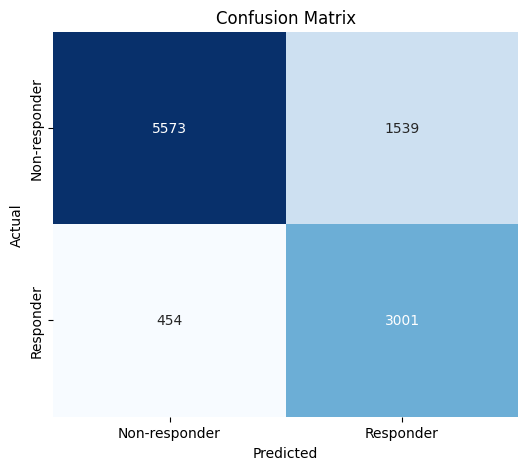

In [11]:
#  3.5 Run hyperparameter tuning and evaluation for ANN

# Step 1: Define and run Optuna study
name = 'ANN'
study_ann = optuna.create_study(direction="maximize")
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"{name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna

# Retrieve best hyperparameters from the ANN Optuna study
best_params = study_ann.best_params

# Compute class imbalance ratio for weighting
w = class_balance(y_train)

#  Build ANN architecture
ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Handle class imbalance via per-sample weighting
sample_weights = np.where(y_train == 1, w, 1)

# Train model
ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# Step 3: Evaluate on test data

# Probability predictions for ROC/AUC
y_prob_ann = ann.predict(X_test)
# Binary predictions using default 0.5 threshold
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


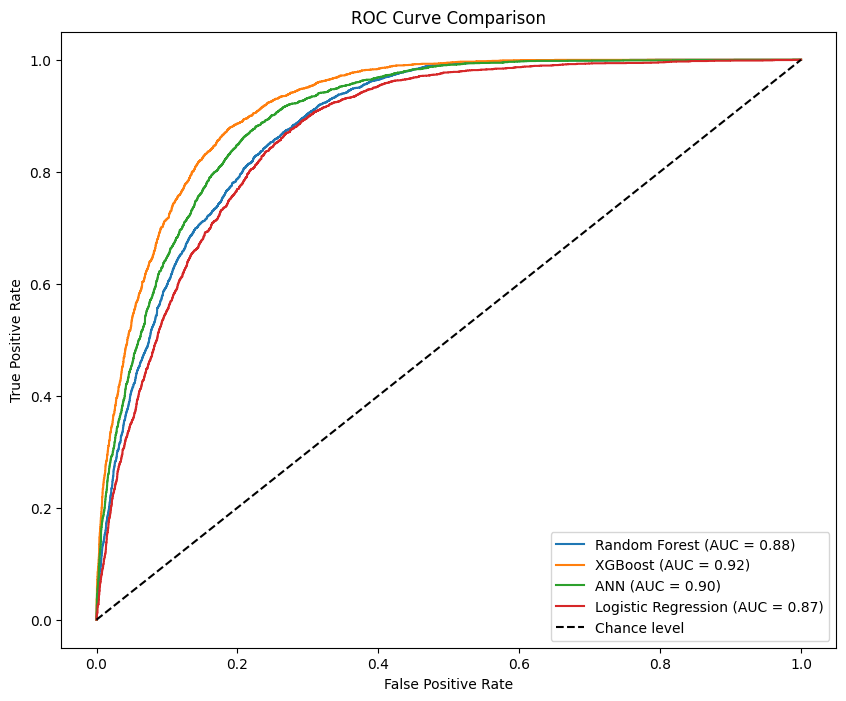

In [12]:
# Model Comparsion - ROC Curve

# Compute ROC and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

In [13]:
# Compute Brier scores (lower = better)
brier_logreg = brier_score_loss(y_test, y_prob_lr)
brier_xgb    = brier_score_loss(y_test, y_prob_gb)
brier_rf     = brier_score_loss(y_test, y_prob_rf)
brier_ann    = brier_score_loss(y_test, y_prob_ann)

# Display results
print(f"Brier Score - Logistic Regression: {brier_logreg:.4f}")
print(f"Brier Score - XGBoost: {brier_xgb:.4f}")
print(f"Brier Score - Random Forest: {brier_rf:.4f}")
print(f"Brier Score - ANN: {brier_ann:.4f}")

Brier Score - Logistic Regression: 0.1479
Brier Score - XGBoost: 0.1115
Brier Score - Random Forest: 0.1383
Brier Score - ANN: 0.1277


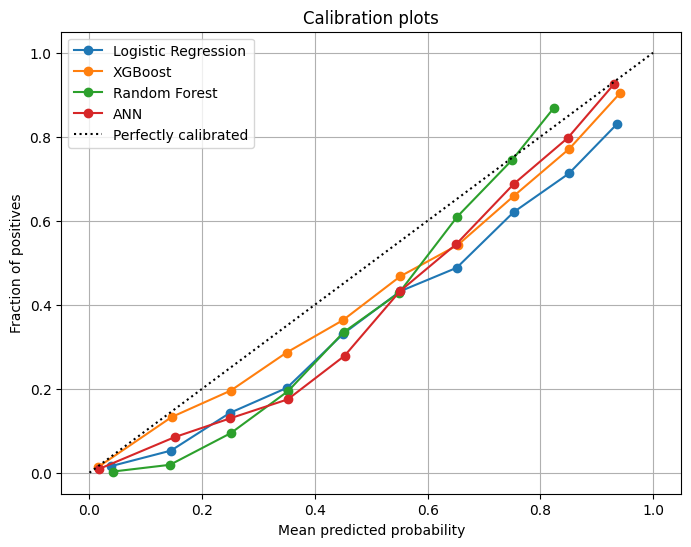

In [14]:
# Calibration Curver Comparison

# Initialize plot
plt.figure(figsize=(8, 6))

# Define models and their predicted probabilities
for model_name, y_prob in [
    ('Logistic Regression', y_prob_lr),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Model Evaluation using Matthews Correlation Coefficient (MCC)

# Define threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary classes
y_pred_logreg = (y_prob_lr > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Compute MCC for each model
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.5615
MCC - XGBoost: 0.6537
MCC - Random Forest: 0.5681
MCC - ANN: 0.6180


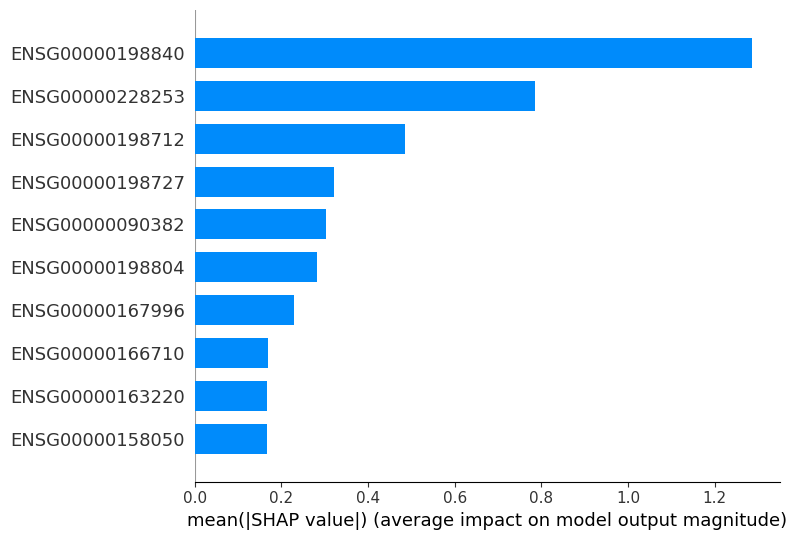

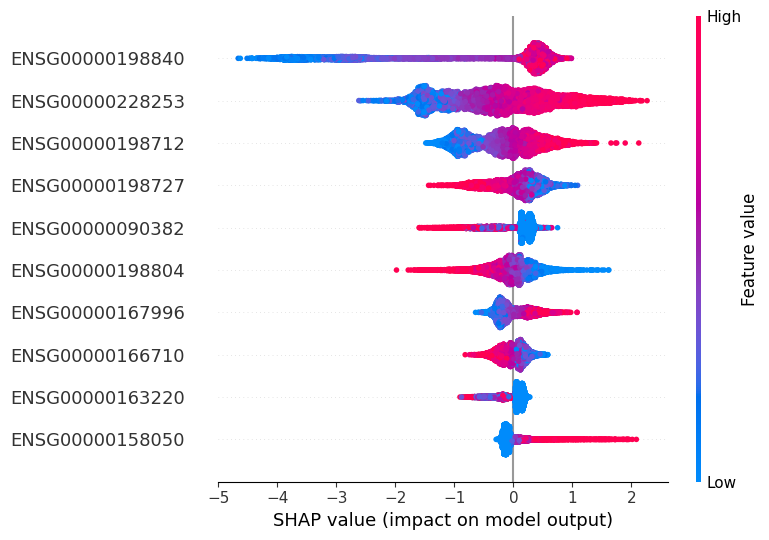

In [16]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)

In [17]:
from sklearn.metrics import f1_score

# Compute F1 Macro for all models
f1_logreg = f1_score(y_test, y_pred_logreg, average='macro')
f1_xgb    = f1_score(y_test, y_pred_xgb, average='macro')
f1_rf     = f1_score(y_test, y_pred_rf, average='macro')
f1_ann    = f1_score(y_test, y_pred_ann, average='macro')

# Display results
print(f"F1 Macro - Logistic Regression: {f1_logreg:.4f}")
print(f"F1 Macro - XGBoost: {f1_xgb:.4f}")
print(f"F1 Macro - Random Forest: {f1_rf:.4f}")
print(f"F1 Macro - ANN: {f1_ann:.4f}")

F1 Macro - Logistic Regression: 0.7691
F1 Macro - XGBoost: 0.8238
F1 Macro - Random Forest: 0.7772
F1 Macro - ANN: 0.7995
